# Preprocessing

MolecularGraph.jl version: 0.10.0

Your chemical structure data may have some inconsistency in molecular graph notation that comes from difference in input data format. Also preferable molecular graph model should be selected according to the application.  `MolecularGraph.jl` offers preprocessing methods that helps unification of expression and making consistent molecular graph model as you like.

- Kekulization
- Implicit/Explicit hydrogen
- Dealing with stereochemistry
- Unifying representation of charges and delocalized electrons
- Extract largest molecular graph


In [1]:
using Pkg
Pkg.activate("..")
using MolecularGraph

  Activating environment at `~/Repository/MolecularGraph.jl_notebook/Project.toml`
Path `../../MolecularGraph.jl` exists and looks like the correct package. Using existing path.
   Resolving package versions...
  No Changes to `~/Repository/MolecularGraph.jl_notebook/Project.toml`
  No Changes to `~/Repository/MolecularGraph.jl_notebook/Manifest.toml`


## Kekulization

SMILES allows aromatic bond notation without specific bond order value. Although we know it is intrinsic expression of aromaticity, it is sometimes inconvenient in the case where we need appearent atom valence to calculate molecular properties. Kekulization is well-known technique to align double bonds along aromatic rings.

Actually, `smilestomol(mol)` method do kekulization by `kekulize!(mol)` in it so usually we don't have to care about it. Here we use `parse(SMILES, mol)` that just parse SMILES to know how `kekulize!` work.
`kekulize!` converts aromatic bonds into single/double bonds.

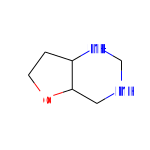

In [2]:
mol = parse(SMILES, "o1ccc2c1cncn2")
molsvg = drawsvg(mol, 150, 150)
# Note: aromatic bond notation (e.g. dashed cycle path or circle in the ring) is not supported yet
display("image/svg+xml",  molsvg)

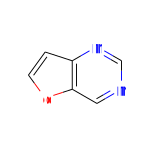

In [3]:
mol = parse(SMILES, "o1ccc2c1cncn2")
kekulize!(mol)
molsvg = drawsvg(mol, 150, 150)
display("image/svg+xml",  molsvg)

Please be careful not to forget to write pyrrole hydrogen. It is not obvious that if nitrogens in aromatic rings are pyrrole-like (-NH-) or pyridine-like (=N-).

Some cheminformatics toolkit may parse pyrrole N without H though it is grammatically wrong. In this case, MolecularGraph.jl returns ErrorException.

In [4]:
mol = smilestomol("n1cccc1")

LoadError: Kekulization failed: Please check if your SMILES is valid (e.g. Pyrrole n should be [nH])

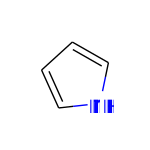

In [5]:
mol = smilestomol("[nH]1cccc1")
mol = removehydrogens(mol)
molsvg = drawsvg(mol, 150, 150)
display("image/svg+xml",  molsvg)

## Implicit/explicit hydrogens

Molecules parsed from `SDFile` and `SMILES` may have some hydrogen atom nodes. Hydrogen nodes can be removed by `removehydrogens`.

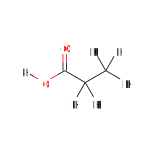

In [6]:
mol = smilestomol("[CH3][CH2]C(=O)[OH]")
molsvg = drawsvg(mol, 150, 150)
display("image/svg+xml",  molsvg)

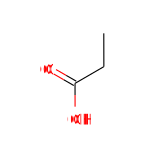

In [7]:
mol = removehydrogens(mol)
molsvg = drawsvg(mol, 150, 150)
display("image/svg+xml",  molsvg)

`removehydrogens(mol, all=true)` (default) will remove all hydrogen nodes whereas `all=false` will remove only trivial hydrogens (are attached to organic atoms, have no charges and are not involved in stereochemistry)

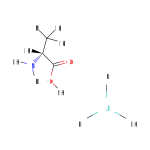

In [8]:
mol = smilestomol("O=C([OH])[C@H]([NH2])[CH3].[AlH3]")
molsvg = drawsvg(mol, 150, 150)
display("image/svg+xml",  molsvg)

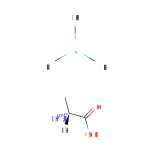

In [9]:
mol = removehydrogens(mol, all=false)
molsvg = drawsvg(mol, 150, 150)
display("image/svg+xml",  molsvg)

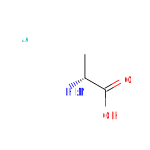

In [10]:
mol = removehydrogens(mol)  # all=true
molsvg = drawsvg(mol, 150, 150)
display("image/svg+xml",  molsvg)

## Dealing with stereochemistry

One more thing `smilestomol` and `sdftomol` will automatically do by default is standardization of stereochemistry notation.

`setstereocenter!` sets stereocenter information to `Atom.stereo` by the same rule as SMILES notation (looking from the lowest indexed atom, 2nd, 3rd, 4th atoms are in clockwise/anticlockwise order). The values are `:clockwise`, `:anticlockwise`, `unspecified` or `atypical`.  If there is implicit hydrogens involved in stereochemistry, its index order priority is considered as same as the atom that the hydrogen is attached. `setstereocenter!` will be called inside `sdftomol` method.

`setdiastereo!` sets diastereomerism information to `Bond.stereo` of double bonds. `:cis`, `:trans` or `:unspecified` will be set according cis/trans configuration of atom nodes at each side of the double bond (If there is two atom nodes on  one side, that of the lower indexed atom node). `setdiastereo!` will be called inside `sdftomol` and `smilestomol` methods.

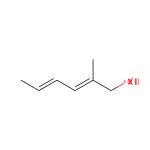

In [11]:
mol = smilestomol("C\\C(CO)=C/C=C/C")
setdiastereo!(mol)
molsvg = drawsvg(mol, 150, 150)
display("image/svg+xml",  molsvg)

Hydrogen nodes attached to the stereocenters can be removed by `removestereohydrogens` with keeping stereochemistry. Similary, explicit hydrogen nodes can be attached to the stereocenters by `addstereohydrogen`. As newly added hydrogen does not have coordinates information, `forcecoordgen=true` option is necessary for `drawsvg` to recalculate 2D coordinates of all atoms.

Note that `removehydrogens(mol, all=true)` can break stereochemistry of the molecule. Make sure to call `removestereohydrogens` before that if you want to work on stereochemistry.

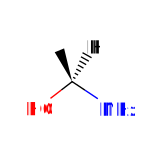

In [12]:
mol = sdftomol(split("""



  5  4  0  0  0  0  0  0  0  0999 V2000
   -4.1517    0.8937    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.7055    1.6866    0.0000 H   0  0  0  0  0  0  0  0  0  0  0  0
   -4.4194    1.5526    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.3812    0.3805    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   -4.8022    0.3917    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
  1  3  1  1  0  0  0
  1  2  1  6  0  0  0
  1  4  1  0  0  0  0
  1  5  1  0  0  0  0
M  END""", "\n"))
molsvg = drawsvg(mol, 150, 150)
display("image/svg+xml",  molsvg)

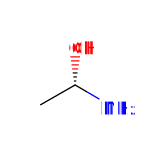

In [13]:
mol = removestereohydrogens(mol)
molsvg = drawsvg(mol, 150, 150; forcecoordgen=true)
display("image/svg+xml",  molsvg)

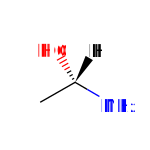

In [14]:
mol = addstereohydrogens(mol)
molsvg = drawsvg(mol, 150, 150; forcecoordgen=true)
display("image/svg+xml",  molsvg)

## Unifying representation of charges and delocalized electrons

Many oxoacids and oniums that are ionized in physiological condition have variations of charge state in actual chemical structure data (e.g free acid or salt). In practice, these molecules are often formatted to uncharged molecule for consistency. `protonateacids!` and `deprotonateoniums!` are convenient methods for this purpose.

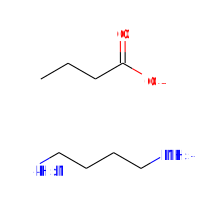

In [15]:
mol = smilestomol("CCCC(=O)[O-].[N+]CCCC[N+]")
molsvg = drawsvg(mol, 200, 200)
display("image/svg+xml",  molsvg)

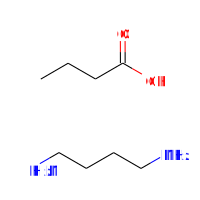

In [16]:
protonateacids!(mol)
deprotonateoniums!(mol)
molsvg = drawsvg(mol, 200, 200)
display("image/svg+xml",  molsvg)

Resonance structures that are often used to describe electron delocalization can be a cause of variation in molecular graph expression.　`depolarize!` and `toallenelike!` may work well for unification of the expression.

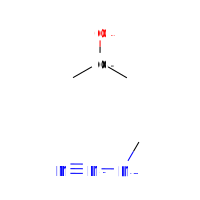

In [17]:
mol = smilestomol("C[C+]([O-])C.C[N-][N+]#N")
molsvg = drawsvg(mol, 200, 200)
display("image/svg+xml",  molsvg)

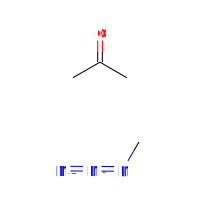

In [18]:
depolarize!(mol)
toallenelike!(mol)
molsvg = drawsvg(mol, 200, 200)
display("image/svg+xml",  molsvg)

## Extract largest molecular graph

Chemical structure `SDFIle` provided by reagent venders often have additives, water molecules and inorganic salts. In most cases, main component have the largest molecular graph, so `extractlargestcomponent` can be used to remove unnecessary components. (Note that this method should be carefully applied because there might be additives that have very large molecular graph. Functional group analysis will provide more meaningful desaltation and dehydration workflow)

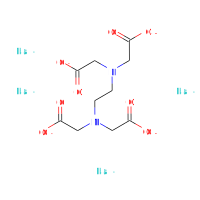

In [19]:
mol = smilestomol("[O-]C(=O)CN(CCN(CC([O-])=O)CC([O-])=O)CC([O-])=O.[Na+].[Na+].[Na+].[Na+]")
molsvg = drawsvg(mol, 200, 200)
display("image/svg+xml",  molsvg)

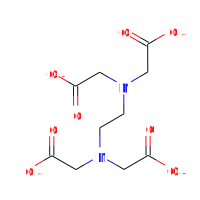

In [20]:
mol = extractlargestcomponent(mol)
molsvg = drawsvg(mol, 200, 200)
display("image/svg+xml",  molsvg)